In [1]:
## the goal of this file is to attempt doing this with pure accelerometer data, along with rolling feature extraction. 
## this data will be fed into a neural network indicating the kind of gesture is being done. 
import json
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
from scipy.signal import find_peaks
from tools import feature_extraction, table, rolling_feature_extraction, reshape_data
import warnings
import os
warnings.filterwarnings("ignore") # ignore all warning messages  



def load_data(file_name):
    # the tap strap has 5 xyz accelerometers
    # and a imu on the thumb. The 
    data = []
    with open(file_name, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    df = pd.DataFrame(data)
    # Break payload into separate columns
    if all(len(i) == 15 for i in df['payload']): # case we are loading in data from the general tap strap 
        df[['thumb_x', 'thumb_y', 'thumb_z', 'index_x', 'index_y', 'index_z', 'middle_x', 'middle_y', 'middle_z', 
            'ring_x', 'ring_y', 'ring_z', 'pinky_x', 'pinky_y', 'pinky_z']] = pd.DataFrame(df['payload'].values.tolist(), index=df.index)
    elif all(len(i) == 6 for i in df['payload']): # case we are loading in imu data for the thumb 
        df[['thumb_imu_x', 'thumb_imu_y', 'thumb_imu_z', 'thumb_imu_pitch', 'thumb_imu_yaw', 'thumb_imu_roll',
            ]] = pd.DataFrame(df['payload'].values.tolist(), index=df.index)
    elif all(len(i) == 21 for i in df['payload']): # case we are loading in merged/interpolated data 
        df[['thumb_imu_x', 'thumb_imu_y', 'thumb_imu_z', 'thumb_imu_pitch', 'thumb_imu_yaw', 'thumb_imu_roll', 'thumb_x', 'thumb_y', 'thumb_z', 'index_x', 'index_y', 'index_z', 'middle_x', 'middle_y', 'middle_z', 
            'ring_x', 'ring_y', 'ring_z', 'pinky_x', 'pinky_y', 'pinky_z' ,
            ]] = pd.DataFrame(df['payload'].values.tolist(), index=df.index)
    else:
        print("Some payloads do not have the expected length of 15 or 6.")
    
    # Drop the original 'payload' column
    df = df.drop(columns=['payload'])
    df
    return df

In [2]:
dir_list = os.listdir("./training_data/finger_taps")
# use regex to remove all numbers from the string
import re
unique_names = list(set([re.sub(r'\d+', '', i) for i in dir_list]))
# remove ds store from the list
# unique_names.remove('.DS_Store')
automated_gestures_dict = {}
# get unique set of gestures
for i in unique_names:
    automated_gestures_dict[i] = len([s for s in dir_list if i in s])
print(automated_gestures_dict)
gesture_folders = [(i, automated_gestures_dict[i]) for i in automated_gestures_dict.keys()]
print(gesture_folders)

{'c': 109, 'b': 123, 'a': 124, 'd': 103}
[('c', 109), ('b', 123), ('a', 124), ('d', 103)]


In [3]:
from tools import rolling_feature_extraction
acc = pd.DataFrame()
count = 0
# '../../data/Still2/imu_data.json'
list_of_dataframes = []

for gesture_name,number_items in gesture_folders:
    print('looking at ',gesture_name, "with ", number_items, "number of folders" )
    for  i in range(number_items):
        if i == 0:
            continue # this is becasue we arent starting with 0 
        # load the data
        file_name = str(f'training_data/finger_taps/{gesture_name}{i}/merged_data.json')
        ndf = load_data(file_name)
        features = rolling_feature_extraction(ndf, use_label = True, interpolated=True,normalize=True)
        count += 1
        list_of_dataframes.append(features)
        acc = pd.concat([acc, features], ignore_index=True)

# add still data from the data_2 folder into our acc
gesture_name = 'still'
print('looking at ',gesture_name, "with ", number_items, "number of folders" )
for  i in range(100):
    if i == 0:
        continue # this is becasue we arent starting with 0 
    # load the data
    file_name = str(f'training_data/data_2/{gesture_name}{i}/merged_data.json')
    ndf = load_data(file_name)
    features = rolling_feature_extraction(ndf, use_label = True, interpolated=True, assign_label=4, normalize=True)
    count += 1
    list_of_dataframes.append(features)

    acc = pd.concat([acc, features], ignore_index=True)
# print("total appendage count", count)
# table(acc)
final_data = acc
print("final data shape", final_data.shape)
print("total appendage count", count)

looking at  c with  109 number of folders
looking at  b with  123 number of folders
looking at  a with  124 number of folders
looking at  d with  103 number of folders
looking at  still with  103 number of folders
final data shape (133343, 106)
total appendage count 554


In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming your data is stored in a pandas DataFrame or similar structure
# Replace 'data' with the name of your DataFrame

# Step 1: Organize the data into sequences
window_size = 100  # Define the window size for each sequence
# num_features = 105  # Number of features in your dataset
# get the number of features
num_features = len(list_of_dataframes[0].columns) - 1
data = list_of_dataframes[0]
sequences = []
labels = []
d = pd.DataFrame()
print(len(list_of_dataframes))

for l in list_of_dataframes[0:700:50]: # check in the first 100 rows, every 10th row
    d = pd.concat([d, l], ignore_index=True)
# for l in list_of_dataframes: # check in the first 100 rows, every 10th row
    # d = pd.concat([d, l], ignore_index=True)
data = d
# for i in range(len(data) - window_size):
#     sequence = data.iloc[i:i+window_size].values
#     # drop the label column
#     sequence = sequence[:, :-1]
#     sequences.append(sequence)
#     # Assuming the last column is the target variable
#     labels.append(data.iloc[i+window_size][-1])

sequences, labels = reshape_data(data=data, window_size=window_size,use_label=True)
# sequences = np.array(sequences)
# labels = np.array(labels)

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)

# Step 3: Create and train the LSTM model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import to_categorical
# get num of unique labels
classes = np.unique(labels)
print("labels: ", classes)
number_classes = len(classes)

labels_one_hot = to_categorical(y_train, num_classes=number_classes)
test_labels_one_hot = to_categorical(y_test, num_classes=number_classes)
print("labels_one_hot: ", labels_one_hot)
# Define LSTM model
model = Sequential([
    # LSTM(units=64, input_shape=(window_size, num_features), return_sequences=True),
    LSTM(units=256, input_shape=(window_size, num_features), return_sequences=True, activation='tanh'),
    LSTM(units=128, return_sequences=False, activation='tanh'),
    Dense(units=128, activation='tanh'),
    Dense(units=number_classes, activation='softmax')  # Output layer with softmax activation

    # Dense(units=1, activation='sigmoid')  # Assuming binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
# model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
model.fit(X_train, labels_one_hot, epochs=10, batch_size=32, validation_split=0.2)
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, test_labels_one_hot)

print(f'Test Accuracy: {accuracy * 100:.2f}%')
# save model 
model.save('./models/lstm_model.h5')
# Display model summary
# model.summary()
# create a heatmap of the confusion matrix



554
X_train shape: (2386, 100, 105)
labels:  [0. 1. 2. 3. 4.]
labels_one_hot:  [[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Epoch 1/10
60/60 [==============================] - 18s 283ms/step - loss: 0.5769 - accuracy: 0.7909 - val_loss: 0.1622 - val_accuracy: 0.9435
Epoch 2/10
60/60 [==============================] - 16s 270ms/step - loss: 0.0635 - accuracy: 0.9796 - val_loss: 0.0211 - val_accuracy: 0.9916
Epoch 3/10
16/60 [=======>......................] - ETA: 10s - loss: 0.0561 - accuracy: 0.9902

KeyboardInterrupt: 

In [30]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming your data is stored in a pandas DataFrame or similar structure
# Replace 'data' with the name of your DataFrame

# Step 1: Organize the data into sequences
window_size = 100  # Define the window size for each sequence
# num_features = 105  # Number of features in your dataset
# get the number of features
num_features = len(list_of_dataframes[0].columns) - 1
data = list_of_dataframes[0]
sequences = []
labels = []
d = pd.DataFrame()
print(len(list_of_dataframes))
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import to_categorical

# classes = np.unique(labels)
# print("labels: ", classes)
number_classes = 5


# print("labels_one_hot: ", labels_one_hot)

model = Sequential([
    # LSTM(units=64, input_shape=(window_size, num_features), return_sequences=True),
    LSTM(units=128, input_shape=(window_size, num_features), return_sequences=False),
    Dense(units=128, activation='relu'),
    Dense(units=number_classes, activation='softmax')  # Output layer with softmax activation

    # Dense(units=1, activation='sigmoid')  # Assuming binary classification
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


for l in list_of_dataframes[100:700:10]: # check in the first 100 rows, every 10th row
    # print the current label of the data
    try: 
        # load the mode
        model = tf.keras.models.load_model('./models/lstm_model.h5')
        print("current label: ", l.iloc[0,-1])
        data = l

        sequences, labels = reshape_data(data=data, window_size=window_size,use_label=True)
    # labels = np.array(labels)

    # Step 2: Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.1, random_state=42)
        print("X_train shape:", X_train.shape)
        # labels_one_hot = to_categorical(y_train, num_classes=number_classes)
        # test_labels_one_hot = to_categorical(y_test, num_classes=number_classes)    

    # Step 3: Create and train the LSTM model

    # get num of unique labels
    
    # Define LSTM model


    # Compile the model

    # Train the model
    # model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
        model.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.2)
    # Evaluate the model on the test set
        loss, accuracy = model.evaluate(X_test, y_test)

        print(f'Test Accuracy: {accuracy * 100:.2f}%')
        # save model 
        model.save('./models/lstm_model.h5')
    except:
        print("error")
        continue
# Display model summary
# model.summary()
# create a heatmap of the confusion matrix
model.save('./models/lstm_model.h5')


554
current label:  2
X_train shape: (34, 100, 105)
Epoch 1/2
1/1 [==============================] - 1s 784ms/step - loss: 12.4537 - accuracy: 0.0000e+00 - val_loss: 11.8033 - val_accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 18ms/step - loss: 10.5907 - accuracy: 0.0000e+00
Test Accuracy: 0.00%
current label:  1
X_train shape: (80, 100, 105)
Epoch 1/2
2/2 [==============================] - 1s 308ms/step - loss: 10.8091 - accuracy: 0.0000e+00 - val_loss: 8.5838 - val_accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 25ms/step - loss: 7.2698 - accuracy: 0.0000e+00
Test Accuracy: 0.00%
current label:  1
X_train shape: (185, 100, 105)
Epoch 1/2
5/5 [==============================] - 1s 110ms/step - loss: 4.3765 - accuracy: 0.0000e+00 - val_loss: 1.2207 - val_accuracy: 0.1081
Epoch 2/2
1/1 [==============================] - 0s 28ms/step - loss: 0.1042 - accuracy: 1.0000
Test Accuracy: 100.00%
current label:  1
X_train shape: (112, 100, 105)


19/19 [==============================] - 2s 80ms/step
len of y_pred 597
[4 3 1 2 4 0 1 0 0 4 0 1 4 0 2 4 4 4 4 2 3 4 2 0 4 2 4 2 0 4 4 4 3 1 0 1 0
 4 4 3 4 4 4 1 4 2 2 0 2 4 4 3 4 2 0 2 2 3 2 0 4 3 2 4 4 4 2 2 4 1 4 2 2 4
 0 4 2 1 1 2 0 4 2 2 2 4 4 4 0 0 4 3 4 4 4 0 1 2 2 0 2 2 1 4 4 4 4 2 0 4 2
 4 4 4 2 3 3 4 4 4 4 2 3 4 4 4 4 4 2 4 4 4 2 1 2 4 0 2 4 4 2 1 4 4 4 4 0 0
 4 2 0 4 4 0 0 2 4 1 1 4 4 4 4 4 4 4 1 4 2 0 0 4 4 1 2 2 2 4 4 4 4 4 1 4 0
 4 0 2 3 4 0 4 1 4 4 2 4 0 4 2 2 4 4 0 4 2 0 2 0 2 4 2 4 1 4 2 0 1 2 1 3 2
 2 1 0 2 2 0 2 4 1 4 4 2 4 3 1 2 4 3 2 4 2 3 2 4 1 4 1 0 2 2 4 2 1 0 0 4 2
 4 2 0 4 4 4 2 4 0 2 0 4 0 2 2 4 0 4 0 4 4 4 4 4 4 4 4 4 4 4 0 4 0 3 2 4 2
 2 1 0 4 1 1 0 3 1 4 4 2 2 1 1 4 2 3 4 1 0 2 1 2 2 3 1 0 0 4 3 4 2 4 4 4 3
 1 3 4 4 4 2 4 4 0 2 3 4 3 4 2 1 1 1 0 0 2 4 4 4 2 4 2 1 3 4 4 4 4 2 4 4 1
 4 2 0 2 1 4 2 4 2 2 4 1 1 4 4 1 4 2 0 0 1 4 0 4 0 4 2 4 4 0 4 2 1 0 2 4 4
 4 0 3 2 0 2 2 3 2 2 0 0 4 2 0 3 0 2 4 1 4 4 4 2 3 4 4 4 4 0 2 4 4 1 0 0 1
 4 4 4 2 4 4 1 0 2 4 3 2 3 4

<Axes: >

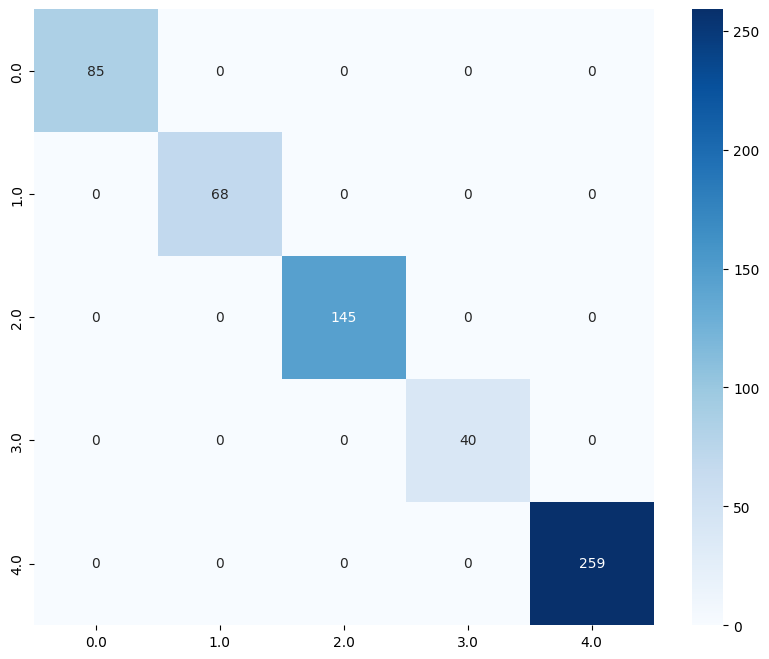

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted class for each sample
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1) # Convert one-hot encoded labels back to a single label
print("len of y_pred", len(y_pred))
print(y_pred)

# Get the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

In [ ]:
import math
# Model parameters

n_features = 105  
n_timesteps = 20

def create_lstm_model():

    model = Sequential()
    model.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(n_timesteps, 104)))
    
    model.add(LSTM(64, activation='tanh')) # Add a second LSTM layer

    # dense layer 
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(1, activation='softmax')) # Output layer
    # model.compile(loss='sarse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

# Create model  
lstm_model = create_lstm_model()

# Loop through dataframes
# take only the 100-105 rows of data
for i, sample in enumerate(list_of_dataframes):
    # normalize the dataframe 
    # normalize  the dataframe
    normalzed_df = sample.copy()
    # for feature_name in sample.columns:
    #     if feature_name != 'label':
    #         max_value = sample[feature_name].max()
    #         min_value = sample[feature_name].min()
    #         normalzed_df[feature_name] = (sample[feature_name] - min_value) / (max_value - min_value)

    sample = normalzed_df
    # sample = (sample - sample.mean()) / (sample.max() - sample.min())
    # Preprocess data
    # truncated_data = sample[:50] 
    # print("truncated_data: ", truncated_data.shape)
    # X = truncated_data.drop('label', axis=1).values
    # X = X.reshape(X.shape[0], n_timesteps,  int(X.shape[1]/n_timesteps))
    # y = truncated_data['label']
    # print("x shape: ", X.shape)
    scaler = StandardScaler()
    # scaled_data = scaler.fit_transform(sample)
    # sample = pd.DataFrame(scaled_data, columns=sample.columns)
    
    # Get input data
    X = sample.drop('label', axis=1).values

    # scaler.fit(X)
    # scaled_x = pd.DataFrame(scaler.transform(X), columns=sample.columns[:-1])
    # X = scaled_x.values
    num_samples = X.shape[0]
    print("num_samples: ", num_samples)

    # Calculate number of complete timesteps
    num_complete_timesteps = math.floor(num_samples / n_timesteps)
    print("num_complete_timesteps: ", num_complete_timesteps)
    print("num features: ", X.shape[1])

    # Drop any leftover samples
    sample = sample[:num_complete_timesteps * n_timesteps]
    # X = X[:num_complete_timesteps * n_timesteps]

    # # Reshape 
    # X = X.reshape(num_complete_timesteps, n_timesteps, n_features)
    # y = sample['label'][:num_complete_timesteps * n_timesteps]
    # print("x shape after: ", X.shape)
    # # reshape y 
    # y = y.values.reshape(num_complete_timesteps, n_timesteps, 1)
    # print("y shape after: ", y.shape)

    print("label: ", sample['label'].head(1))

    df = sample.drop('label', axis=1)
    #print the label 
    df = df.values.reshape(num_complete_timesteps, n_timesteps, n_features)
    # One-hot encode target data 
    # gestures = ['wave', 'clap', 'punch']
    # y = np.zeros((len(y), len(gestures)))
    # for i, gesture in enumerate(y):
    #     y[i, gestures.index(gesture)] = 1 

    # Now split into X and y
    X = df[:, :, :-1] 
    y = df[:, -1, -1]
    print("x shape after: ", X.shape)
    print("y shape after: ", y.shape)

# Split data into train/test
    # X_train, X_test, y_train, y_test = train_test_split(X, y)
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model 
    lstm_model.fit(X_train, y_train, epochs=2, batch_size=10, validation_data=(X_test, y_test))

    # Evaluate model
    loss, accuracy = lstm_model.evaluate(X_test, y_test)
    print(f'Accuracy for DF {i}: {accuracy*100:.2f}%')

    # run a prediction on the model

    print("running a prediction on the model")
    prediction = lstm_model.predict(X_test)
    print("prediction: ", prediction)